# **Time Series Forecasting with TensorFlow: RNN Baseline Model**



## **1. Generate Synthetic Data**

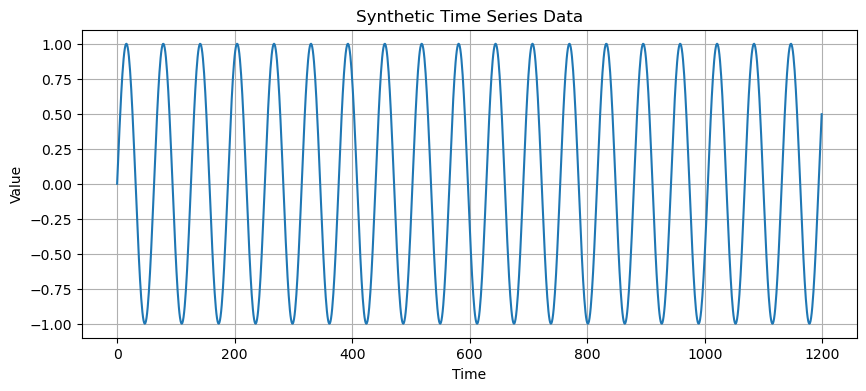

In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model


# Generate synthetic time series data
time = np.arange(1200) #time steps
series = np.sin(0.1 * time) # Sine wave with noise

# Plot the synthetic data
plt.figure(figsize=(10, 4))
plt.plot(time, series)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data')
plt.grid(True)
plt.show()

## **2. What is `split_time`? Explaining the slicing and visualization.**


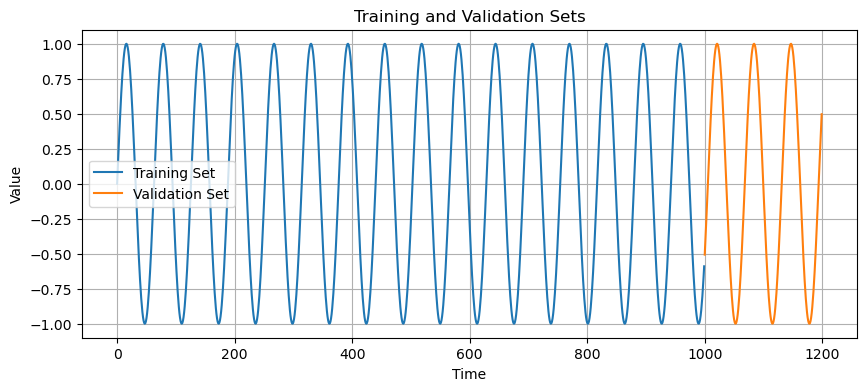

In [7]:
# Split the data
split_time = 1000
x_train = series[:split_time]
x_valid = series[split_time:]

# Plot the split
plt.figure(figsize=(10, 4))
plt.plot(time[:split_time], x_train, label='Training Set')
plt.plot(time[split_time:], x_valid, label='Validation Set')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Training and Validation Sets')
plt.legend()
plt.grid(True)
plt.show()

# **3. What is `windowed_dataset`, and why do we use it?**


In [8]:
import tensorflow as tf

# Define a windowed dataset function
def windowed_dataset(series, window_size, batch_size):
    # 1. Convert the time series into individual elements
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # 2. Create windows of size (window_size + 1)
    # Each window includes `window_size` inputs (features) and 1 label (the next value)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # 3. Flatten each window
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))

    # 4. Split each window into features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # 5. Shuffle the windows
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(1)

    # Return the prepared dataset
    return dataset


# Define parameters
window_size = 20
batch_size = 32

# Create windowed datasets
train_dataset = windowed_dataset(x_train, window_size, batch_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size)

## **4. What is the model seeing and learning?**

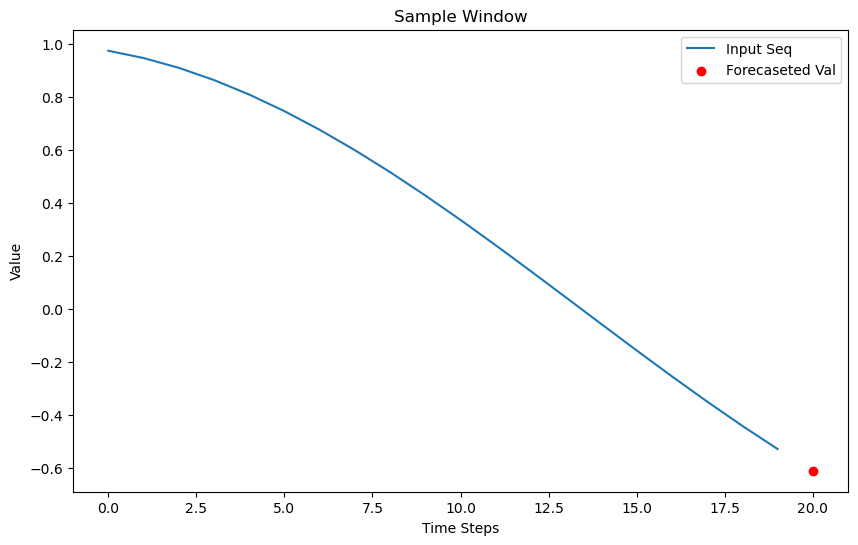

In [9]:
# Visualize a single sample window
for sample_input, sample_output in train_dataset.take(1):
    plt.figure(figsize=(10, 6))
    plt.plot(range(window_size), sample_input[0].numpy(), label='Input Seq')
    plt.scatter(window_size, sample_output[0].numpy(), label='Forecaseted Val', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Sample Window')
    plt.legend()
    plt.show()
    break

## **5. Build and Compile the Model**

In [13]:
# Build the model
inputs = layers.Input(shape=[window_size, 1], name='Input_Layer')
x = layers.SimpleRNN(20, activation='relu', name='RNN_layer')(inputs)
outputs = layers.Dense(1, name='Output_Layer')(x)

rnn_model = Model(inputs=inputs, outputs=outputs, name='RNN_Model')

# Compile the model
rnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])
rnn_model.summary()

Model: "RNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN_layer (SimpleRNN)           │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

## **6. Train the model**

In [16]:
# Train the model
history = rnn_model.fit(
    train_dataset.repeat(),
    epochs=10,
    validation_data=valid_dataset.repeat(),
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_valid) // batch_size
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5473 - mse: 0.5473 - val_loss: 0.2151 - val_mse: 0.2151
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1298 - mse: 0.1298 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 4.5614e-04 - val_mse: 4.5614e-04
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6776e-04 - mse: 4.6776e-04 - val_loss: 8.5017e-04 - val_mse: 8.5017e-04
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0679e-04 - mse: 5.0679e-04 - val_loss: 3.7817e-04 - val_mse: 3.7817e-04
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7344e-04 - mse: 3.7344e-04 - val_loss: 4.1178e-04 - val_mse: 4.1178e-04
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7663e-04 - mse: 3.7663e-04 - val_loss: 3.2486e-04 - val_mse: 3.2486e-04


## **7. Plot performance using loss—NOT accuracy.**


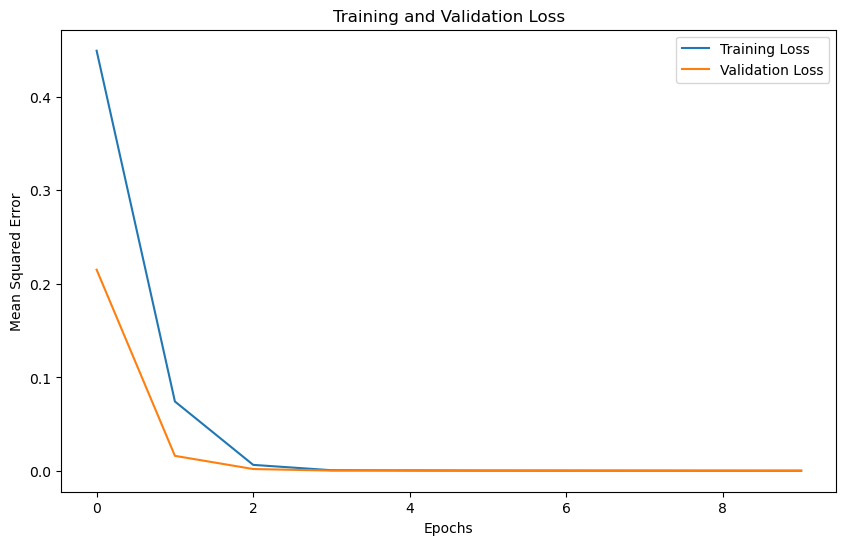

In [17]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## **8. Make Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


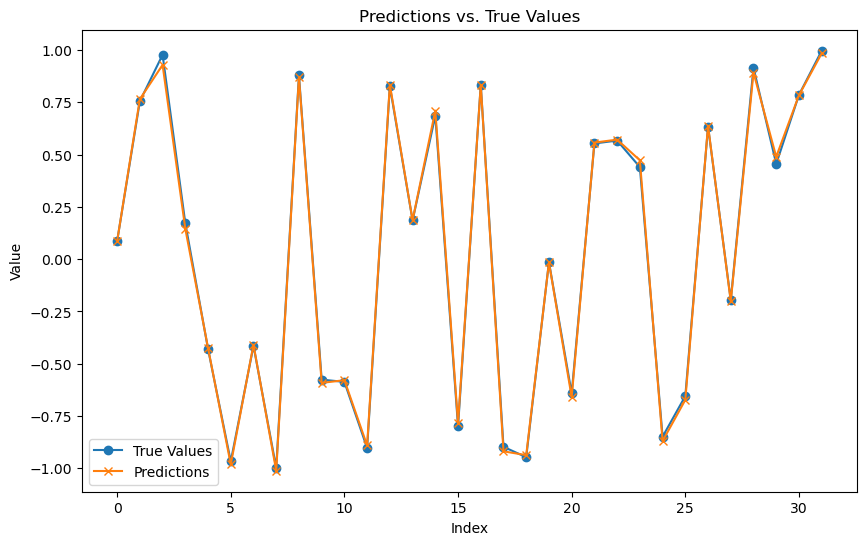

In [19]:
# Make predictions
predictions = []
true_values = []
for input_batch, target_batch in valid_dataset.take(1):
    predictions = rnn_model.predict(input_batch).flatten()
    true_values = target_batch.numpy()
    break

# Plot predictions vs. true values
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', marker='o')
plt.plot(predictions, label='Predictions', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predictions vs. True Values')
plt.legend()
plt.show()